In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Missing Values Imputation

This notebook explores various missing value imputation techniques and their impact on model performance.

In [8]:
df = pd.read_csv('HousingData.csv') 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


       Total   Percent
CRIM      20  3.952569
ZN        20  3.952569
INDUS     20  3.952569
CHAS      20  3.952569
AGE       20  3.952569
LSTAT     20  3.952569


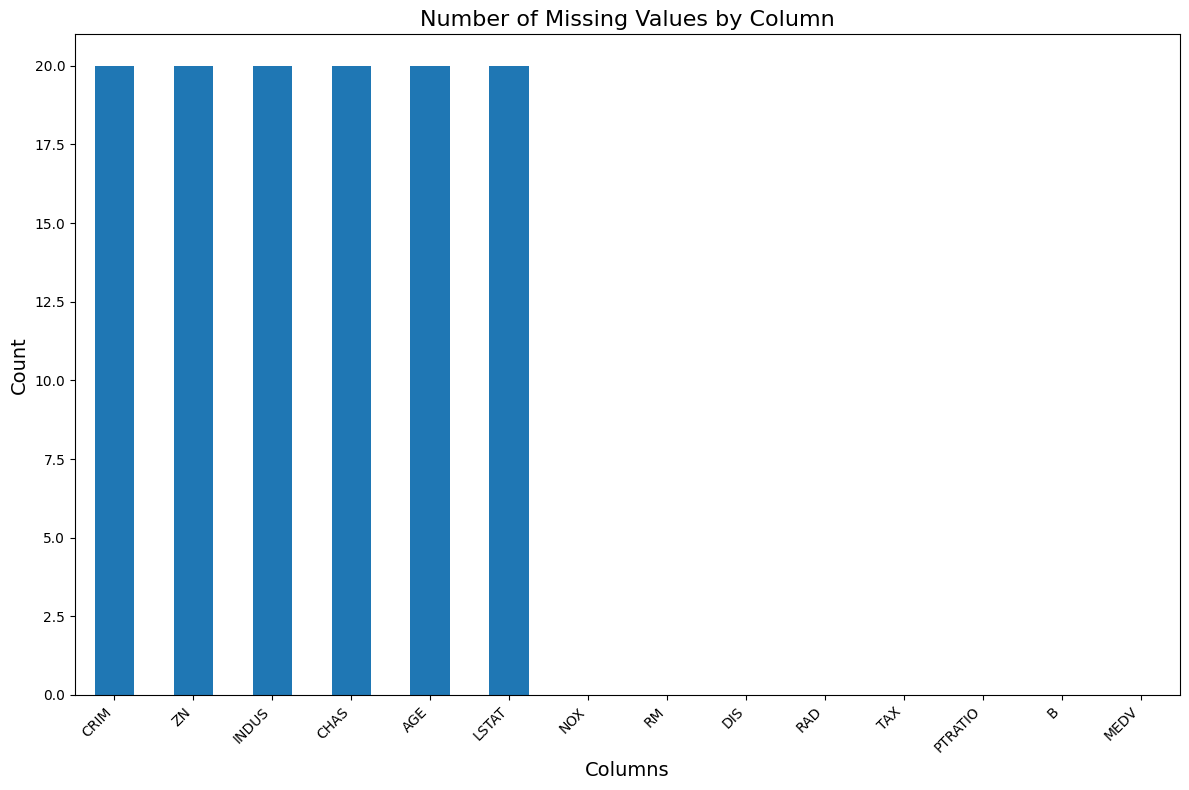

In [10]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
missing_data = pd.concat([missing_values, missing_percent], axis=1, keys=['Total', 'Percent'])

print(missing_data[missing_data['Total'] > 0])

plt.figure(figsize=(12, 8))
ax = missing_values.plot(kind='bar', figsize=(12, 8))
plt.title('Number of Missing Values by Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [11]:
df['target'] = (df['MEDV'] > 25).astype(int)

X = df.drop(['MEDV', 'target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (354, 13)
Testing set shape: (152, 13)


## Creating Imputers

We'll create various imputers from scikit-learn and reparo libraries:

In [12]:
imputer_mean = SimpleImputer(strategy='mean')
imputer_median = SimpleImputer(strategy='median')
imputer_most_frequent = SimpleImputer(strategy='most_frequent')
imputer_constant = SimpleImputer(strategy='constant', fill_value=0)

# Import KNN imputer from sklearn instead of reparo
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # needed for IterativeImputer
from sklearn.impute import IterativeImputer

# Create sklearn-based imputers instead of reparo imputers
imputer_knn = KNNImputer(n_neighbors=5)
imputer_iterative = IterativeImputer(random_state=42, max_iter=10)

# Creating custom imputation methods
def random_imputer(X):
    X_imputed = X.copy()
    for col in X.columns:
        mask = X_imputed[col].isna()
        n_missing = mask.sum()
        if n_missing > 0:
            # Generate random values from the distribution of the column
            random_values = np.random.choice(X_imputed[col].dropna(), size=n_missing)
            X_imputed.loc[mask, col] = random_values
    return X_imputed

class CustomRandomImputer:
    def __init__(self):
        pass
    def fit(self, X):
        self.X_train = X
        return self
    def transform(self, X):
        return random_imputer(X)

imputer_random = CustomRandomImputer()

# Define dictionary of imputers
imputers = {
    'Mean': imputer_mean,
    'Median': imputer_median,
    'Most_Frequent': imputer_most_frequent,
    'Constant': imputer_constant,
    'KNN': imputer_knn,
    'Iterative': imputer_iterative,
    'Random': imputer_random
}

## Training Imputers and Filling Missing Values

We'll train each imputer on the training data and then apply them to both training and testing data.

In [13]:
imputed_data = {}

def apply_sklearn_imputer(imputer_name, imputer):
    imputer.fit(X_train)
    X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)
    return X_train_imputed, X_test_imputed

def apply_custom_imputer(imputer_name, imputer):
    imputer.fit(X_train)
    X_train_imputed = imputer.transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    return X_train_imputed, X_test_imputed

for name, imputer in imputers.items():
    try:
        print(f"Applying {name} imputer...")
        if name in ['Mean', 'Median', 'Most_Frequent', 'Constant', 'KNN', 'Iterative']:
            X_train_imputed, X_test_imputed = apply_sklearn_imputer(name, imputer)
        else:
            X_train_imputed, X_test_imputed = apply_custom_imputer(name, imputer)
        
        imputed_data[name] = {
            'train': X_train_imputed,
            'test': X_test_imputed
        }
        print(f"Successfully applied {name} imputer")
    except Exception as e:
        print(f"Error applying {name} imputer: {e}")

Applying Mean imputer...
Successfully applied Mean imputer
Applying Median imputer...
Successfully applied Median imputer
Applying Most_Frequent imputer...
Successfully applied Most_Frequent imputer
Applying Constant imputer...
Successfully applied Constant imputer
Applying KNN imputer...
Successfully applied KNN imputer
Applying Iterative imputer...
Successfully applied Iterative imputer
Applying Random imputer...
Successfully applied Random imputer


## Model Training and Evaluation

Now we'll train different models on each imputed dataset and evaluate their performance.

In [14]:
# Create models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = {}

scaler = StandardScaler()

for imputer_name, data in imputed_data.items():
    X_train_imputed = data['train']
    X_test_imputed = data['test']
    
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    results[imputer_name] = {}
    
    for model_name, model in models.items():
        try:
            model.fit(X_train_scaled, y_train)
            
            y_pred = model.predict(X_test_scaled)
            
            accuracy = accuracy_score(y_test, y_pred)
            
            results[imputer_name][model_name] = accuracy
            
            print(f"Imputer: {imputer_name}, Model: {model_name}, Accuracy: {accuracy:.4f}")
        except Exception as e:
            print(f"Error with {imputer_name} and {model_name}: {e}")
            results[imputer_name][model_name] = None

Imputer: Mean, Model: Logistic Regression, Accuracy: 0.9276
Imputer: Mean, Model: Gaussian Naive Bayes, Accuracy: 0.6711
Imputer: Mean, Model: Decision Tree, Accuracy: 0.9211
Imputer: Mean, Model: Random Forest, Accuracy: 0.9408
Imputer: Median, Model: Logistic Regression, Accuracy: 0.9276
Imputer: Median, Model: Gaussian Naive Bayes, Accuracy: 0.6579
Imputer: Median, Model: Decision Tree, Accuracy: 0.9276
Imputer: Median, Model: Random Forest, Accuracy: 0.9342
Imputer: Most_Frequent, Model: Logistic Regression, Accuracy: 0.9276
Imputer: Most_Frequent, Model: Gaussian Naive Bayes, Accuracy: 0.6645
Imputer: Most_Frequent, Model: Decision Tree, Accuracy: 0.9276
Imputer: Most_Frequent, Model: Random Forest, Accuracy: 0.9342
Imputer: Constant, Model: Logistic Regression, Accuracy: 0.9342
Imputer: Constant, Model: Gaussian Naive Bayes, Accuracy: 0.6711
Imputer: Constant, Model: Decision Tree, Accuracy: 0.9276
Imputer: Constant, Model: Random Forest, Accuracy: 0.9474
Imputer: KNN, Model: Log

## Results Summary

Let's create a summary table to compare the performance of different imputation methods and models.

Top 10 performing combinations:


,Imputation Algorithm,Prediction Algorithm,Accuracy
15,Constant,Random Forest,0.947368
3,Mean,Random Forest,0.940789
19,KNN,Random Forest,0.940789
23,Iterative,Random Forest,0.934211
7,Median,Random Forest,0.934211
11,Most_Frequent,Random Forest,0.934211
12,Constant,Logistic Regression,0.934211
0,Mean,Logistic Regression,0.927632
26,Random,Decision Tree,0.927632
24,Random,Logistic Regression,0.927632



Comparison across all methods:


Prediction Algorithm,Decision Tree,Gaussian Naive Bayes,Logistic Regression,Random Forest
Imputation Algorithm,,,,
Constant,0.927632,0.671053,0.934211,0.947368
Iterative,0.921053,0.657895,0.927632,0.934211
KNN,0.927632,0.657895,0.927632,0.940789
Mean,0.921053,0.671053,0.927632,0.940789
Median,0.927632,0.657895,0.927632,0.934211
Most_Frequent,0.927632,0.664474,0.927632,0.934211
Random,0.927632,0.671053,0.927632,0.927632


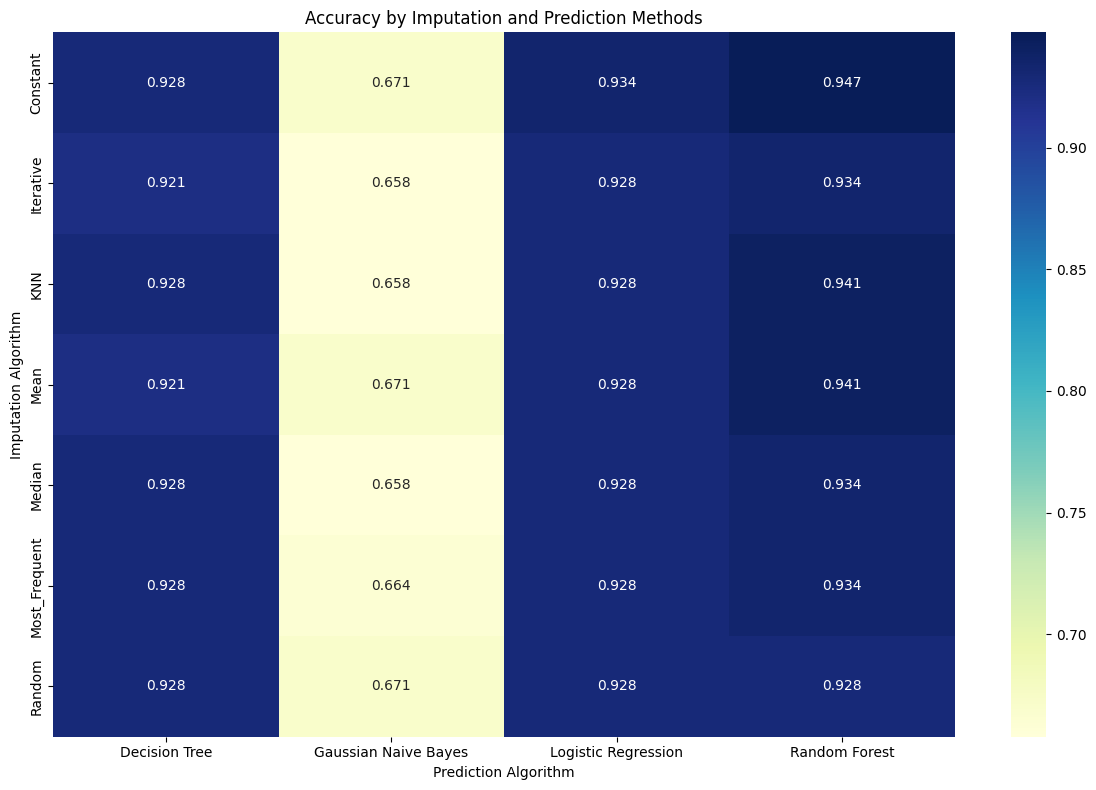

In [15]:
result_rows = []
for imputer_name, model_results in results.items():
    for model_name, accuracy in model_results.items():
        if accuracy is not None:
            result_rows.append({
                'Imputation Algorithm': imputer_name,
                'Prediction Algorithm': model_name,
                'Accuracy': accuracy
            })

results_df = pd.DataFrame(result_rows)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("Top 10 performing combinations:")
display(results_df.head(10))

pivot_results = results_df.pivot(index='Imputation Algorithm', 
                                columns='Prediction Algorithm', 
                                values='Accuracy')

print("\nComparison across all methods:")
display(pivot_results)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_results, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Accuracy by Imputation and Prediction Methods')
plt.tight_layout()
plt.show()